In [ ]:
import os, re, math, json, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from dateutil import tz

# Colab / Drive mount
try:
    from google.colab import drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)

try:
    import pvlib
    HAS_PVLIB = True
except Exception:
    HAS_PVLIB = False

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression

# plotting style
plt.rcParams.update({"figure.figsize": (10, 5), "axes.grid": True})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent")

GLOB_PATTERNS = [
    "**/ALL_SITES_merged*.csv",
    "*ALL_SITES_merged*.csv",
]

CACHE_PRIORITY = ["**/ALL_SITES_merged*.feather", "**/ALL_SITES_merged*.parquet"]

PREFERRED_COLS = [
    # identifiers
    "timestamp","time","datetime","date_time","ts","ts_utc","UTC","Timestamp",
    "site_id","site","region","zone","location",
    "lat","latitude","lon","longitude",
    # targets
    "target_solar_mw","solar_mw","solar_generation","pv_mw",
    "target_wind_mw","wind_mw","wind_generation",
    # meteo core
    "met_ghi","ghi","global_horizontal_irradiance",
    "met_dni","dni","met_dhi","dhi",
    "met_cloud_cover","total_cloud_cover","cloud_cover",
    "met_temp_c","t2m_c","temperature_c",
    "met_pressure_hpa","surface_pressure_hpa","pressure_hpa",
    "met_wind_speed_10m","wind_speed_10m","ws10",
    "met_wind_speed_100m","wind_speed_100m","ws100",
    "u10","v10","u100","v100"
]

LOCAL_TZ = "Europe/Brussels"
HORIZONS = [1, 3, 6, 24]

print("Root:", ROOT_DIR)


Root: /content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent


In [ ]:
def find_files(root: Path, patterns):
    files = []
    for pat in patterns:
        files.extend(root.glob(pat))
    # De-duplicate & sort by name for reproducibility
    uniq = sorted(set([f for f in files if f.is_file()]))
    return uniq

# Prefer cached feather/parquet if present
cache_files = find_files(ROOT_DIR, CACHE_PRIORITY)
csv_files   = find_files(ROOT_DIR, GLOB_PATTERNS)

print(f"Found {len(cache_files)} cache files and {len(csv_files)} CSV files.")
for f in (cache_files[:5] + csv_files[:5]):
    print(" •", f)

assert cache_files or csv_files, "No files found. Check ROOT_DIR or GLOB_PATTERNS."


Found 0 cache files and 4 CSV files.
 • /content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/ALL_SITES_merged_AMERICAS.csv
 • /content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/ALL_SITES_merged_ASIA.csv
 • /content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/ALL_SITES_merged_AUSTRALIA.csv
 • /content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/ALL_SITES_merged_EUROPE.csv


In [ ]:
# column options map (added more timestamp aliases)
COLS = {
    "timestamp": ["ts_utc","UTC","Timestamp","timestamp","time","datetime","date_time","ts"],
    "site": ["site_id", "site", "region", "zone", "location"],
    "lat": ["lat", "latitude"],
    "lon": ["lon", "longitude"],
    "solar_target": ["target_solar_mw", "solar_mw", "solar_generation", "pv_mw"],
    "wind_target":  ["target_wind_mw", "wind_mw", "wind_generation"],
    "ghi":  ["met_ghi", "ghi", "global_horizontal_irradiance"],
    "dni":  ["met_dni", "dni"],
    "dhi":  ["met_dhi", "dhi"],
    "cloud":["met_cloud_cover", "total_cloud_cover", "cloud_cover"],
    "temp": ["met_temp_c", "t2m_c", "temperature_c"],
    "press":["met_pressure_hpa", "surface_pressure_hpa", "pressure_hpa"],
    "ws10": ["met_wind_speed_10m", "wind_speed_10m", "ws10"],
    "ws100":["met_wind_speed_100m", "wind_speed_100m", "ws100"],
    "u10":  ["u10"],
    "v10":  ["v10"],
    "u100": ["u100"],
    "v100": ["v100"],
}

def first_existing(df_cols, candidates):
    for c in candidates:
        if c in df_cols:
            return c
    return None

CONTINENT_REGEX = re.compile(r"(EU|Europe|US|USA|NA|NorthAmerica|SA|SouthAmerica|AMERICAS|AS|Asia|AF|Africa|AU|Australia|Oceania)", re.I)

def infer_region_from_name(path: Path):
    m = CONTINENT_REGEX.search(path.name) or CONTINENT_REGEX.search(str(path.parent))
    return (m.group(1).upper() if m else "UNK")

def read_any(path: Path, preferred_cols=None):
    ext = path.suffix.lower()
    if ext in [".feather", ".ft"]:
        return pd.read_feather(path)
    if ext in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    # CSV: read only intersection to avoid "usecols" errors
    if preferred_cols:
        allowed = set(preferred_cols)
        return pd.read_csv(path, usecols=lambda c: (c in allowed))
    else:
        return pd.read_csv(path)

def to_datetime_utc(s):
    return pd.to_datetime(s, errors="coerce", utc=True)


In [ ]:
frames = []
read_order = (find_files(ROOT_DIR, CACHE_PRIORITY) or []) + find_files(ROOT_DIR, GLOB_PATTERNS)

print(f"Reading {len(read_order)} files …")
for idx, f in enumerate(read_order, 1):
    try:
        df_i = read_any(f, preferred_cols=PREFERRED_COLS)
        if df_i.empty:
            print(f"Empty or no matching cols: {f}"); continue

        df_i = df_i.loc[:, ~df_i.columns.duplicated()].copy()
        df_i["continent"] = infer_region_from_name(f)

        # find ANY plausible timestamp col present in this shard
        ts_cand = first_existing(df_i.columns, COLS["timestamp"])
        if not ts_cand:
            # last-resort: try to auto-detect a datetime-like column by name heuristic
            ts_guess = [c for c in df_i.columns if "time" in c.lower() or "date" in c.lower() or "ts" == c.lower()]
            ts_cand = ts_guess[0] if ts_guess else None
        if not ts_cand:
            print(f"Skipping (no time column found): {f}")
            continue

        df_i["ts_utc"] = to_datetime_utc(df_i[ts_cand])
        df_i = df_i.dropna(subset=["ts_utc"])

        # if original ts col differs, drop it to avoid dup
        if ts_cand != "ts_utc" and ts_cand in df_i.columns:
            # keep original too if you want; otherwise drop:
            df_i.drop(columns=[ts_cand], inplace=True)

        frames.append(df_i)
        if idx % 5 == 0:
            print(f"  …read {idx} files")
    except Exception as e:
        print(f"Skipped {f} due to: {e}")

assert frames, "No data loaded — check ROOT_DIR/patterns or sample a single CSV to confirm headers."
df = pd.concat(frames, axis=0, ignore_index=True)
df = df.loc[:, ~df.columns.duplicated()].copy()
df = df.sort_values("ts_utc")

print("Merged shape:", df.shape)
print("Continents:", df["continent"].value_counts().to_dict())
df.head(3)


Reading 4 files …
Merged shape: (2698080, 15)
Continents: {'EU': 946080, 'AMERICAS': 876000, 'AS': 770880, 'AU': 105120}


,site_id,lat,lon,met_ghi,met_dni,met_dhi,met_temp_c,met_pressure_hpa,met_cloud_cover,met_wind_speed_10m,met_wind_speed_100m,target_wind_mw,target_solar_mw,continent,ts_utc
0,AR_ComodoroRivadavia,-45.8641,-67.4805,38.0,6.0,32.0,18.8,994.1,100,28.1,40.1,0.0,0.032948,AMERICAS,2022-01-01 00:00:00+00:00
157680,CL_Calama_Antofagasta,-22.4540,-68.9290,6.0,3.0,3.0,20.0,782.1,0,16.4,25.3,0.0,0.005198,AMERICAS,2022-01-01 00:00:00+00:00
735840,US_TX_Lubbock,33.5779,-101.8552,22.0,1.0,21.0,12.1,893.7,100,28.0,45.0,0.0,0.019613,AMERICAS,2022-01-01 00:00:00+00:00


In [ ]:
# map keys we’ll use later
site_col  = first_existing(df.columns, COLS["site"])
solar_col = first_existing(df.columns, COLS["solar_target"])
wind_col  = first_existing(df.columns, COLS["wind_target"])
ghi_col   = first_existing(df.columns, COLS["ghi"])
dni_col   = first_existing(df.columns, COLS["dni"])
dhi_col   = first_existing(df.columns, COLS["dhi"])
cloud_col = first_existing(df.columns, COLS["cloud"])
temp_col  = first_existing(df.columns, COLS["temp"])
press_col = first_existing(df.columns, COLS["press"])
ws10_col  = first_existing(df.columns, COLS["ws10"])
ws100_col = first_existing(df.columns, COLS["ws100"])
u10_col   = first_existing(df.columns, COLS["u10"])
v10_col   = first_existing(df.columns, COLS["v10"])
u100_col  = first_existing(df.columns, COLS["u100"])
v100_col  = first_existing(df.columns, COLS["v100"])

# assert minimal fields
assert site_col is not None, "Need a site/region identifier column in the merged data."
assert (solar_col is not None) or (wind_col is not None), " Need at least one target (solar or wind)."

# local time features
local_tz = tz.gettz(LOCAL_TZ)
df["ts_local"] = df["ts_utc"].dt.tz_convert(local_tz)
df["hour"]     = df["ts_local"].dt.hour
df["doy"]      = df["ts_local"].dt.dayofyear
df["month"]    = df["ts_local"].dt.month
df["weekday"]  = df["ts_local"].dt.weekday
df["is_weekend"] = df["weekday"] >= 5

print("Rows:", len(df), "| Sites:", df[site_col].nunique(), "| Continents:", df["continent"].nunique())


Rows: 2698080 | Sites: 154 | Continents: 4


In [ ]:
# basic physical corrections
for col in [ghi_col, dni_col, dhi_col]:
    if col and col in df:
        df.loc[df[col] < 0, col] = 0

# daylight detection (prefer GHI threshold; pvlib optional)
if solar_col:
    if ghi_col and ghi_col in df:
        df["is_daylight"] = df[ghi_col] > 5
    else:
        # fallback heuristic
        df["is_daylight"] = df["hour"].between(6, 18)
    df["solar_struct_zero"] = (df[solar_col].fillna(0) <= 0) & (~df["is_daylight"])

# wind calm flag
if wind_col:
    df["wind_near_zero"] = df[wind_col].fillna(0) <= 0.05


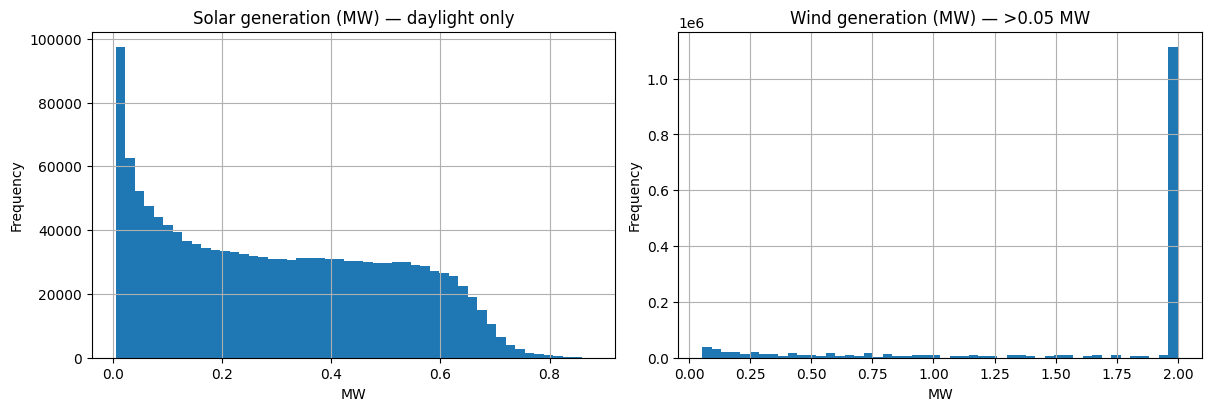

In [ ]:
def safe_series(col):
    return df[col].astype(float).replace([np.inf, -np.inf], np.nan)

fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)

# Solar (daylight only)
if solar_col in df:
    mask = df["is_daylight"].fillna(False)
    x = safe_series(solar_col)[mask].dropna()
    axes[0].hist(x, bins=50)
    axes[0].set_title("Solar generation (MW) — daylight only")
    axes[0].set_xlabel("MW"); axes[0].set_ylabel("Frequency")
else:
    axes[0].axis("off")

# Wind (exclude near-zero calm)
if wind_col in df:
    mask = ~df["wind_near_zero"].fillna(False)
    x = safe_series(wind_col)[mask].dropna()
    axes[1].hist(x, bins=50)
    axes[1].set_title("Wind generation (MW) — >0.05 MW")
    axes[1].set_xlabel("MW"); axes[1].set_ylabel("Frequency")
else:
    axes[1].axis("off")

plt.show()


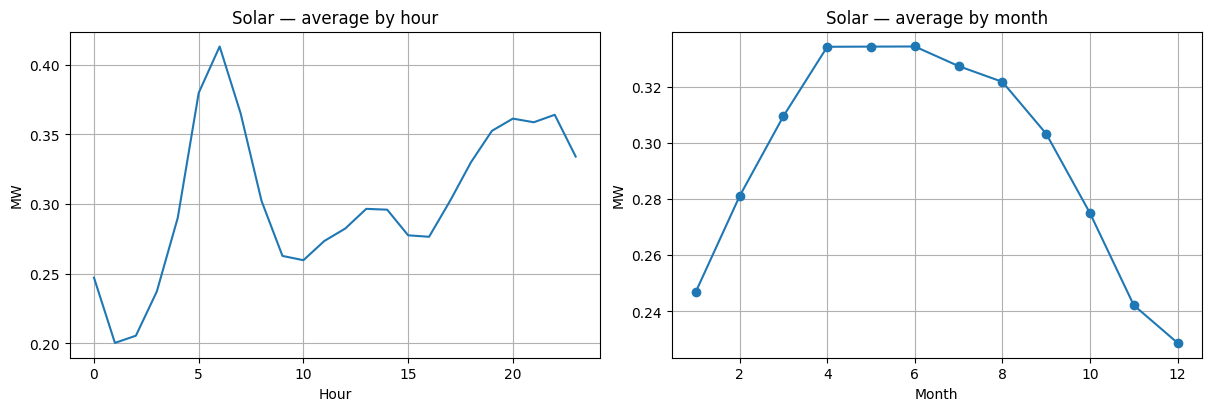

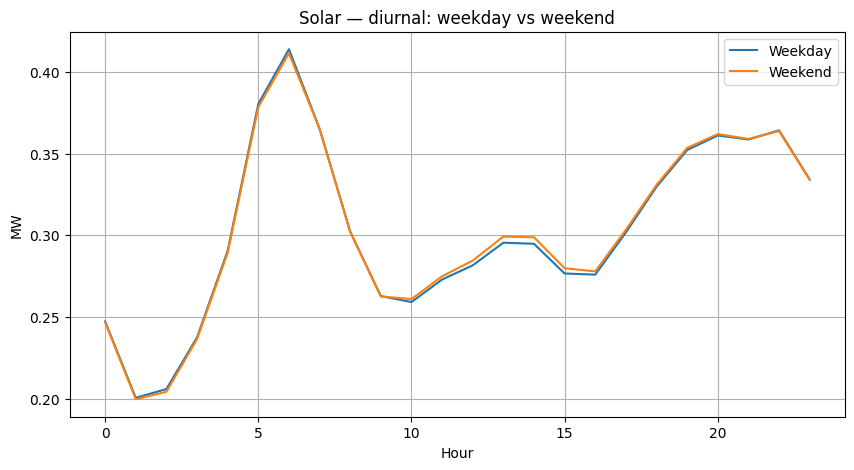

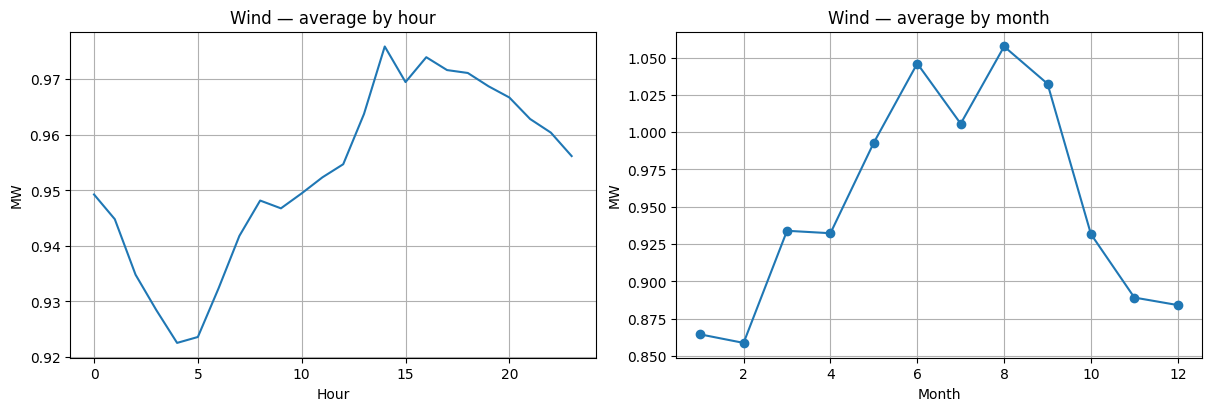

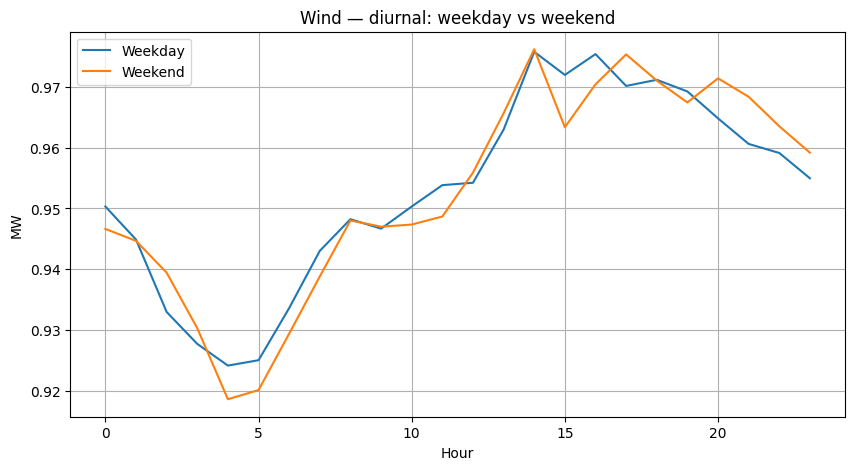

In [ ]:
def seasonality_plot(series_col, title_prefix):
    g = df[[series_col, "hour", "month", "is_weekend"]].copy()
    g = g.dropna(subset=[series_col])
    if series_col == solar_col:
        g = g[df["is_daylight"]]

    diurnal = g.groupby("hour")[series_col].mean()
    monthly = g.groupby("month")[series_col].mean()

    fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)
    diurnal.plot(ax=axes[0]); axes[0].set_title(f"{title_prefix} — average by hour")
    axes[0].set_xlabel("Hour"); axes[0].set_ylabel("MW")
    monthly.plot(ax=axes[1], marker="o"); axes[1].set_title(f"{title_prefix} — average by month")
    axes[1].set_xlabel("Month"); axes[1].set_ylabel("MW")
    plt.show()

    ww = g.groupby(["is_weekend", "hour"])[series_col].mean().unstack(0)
    ww.columns = ["Weekday", "Weekend"]
    ww.plot(title=f"{title_prefix} — diurnal: weekday vs weekend"); plt.xlabel("Hour"); plt.ylabel("MW"); plt.show()

if solar_col in df:
    seasonality_plot(solar_col, "Solar")
if wind_col in df:
    seasonality_plot(wind_col, "Wind")


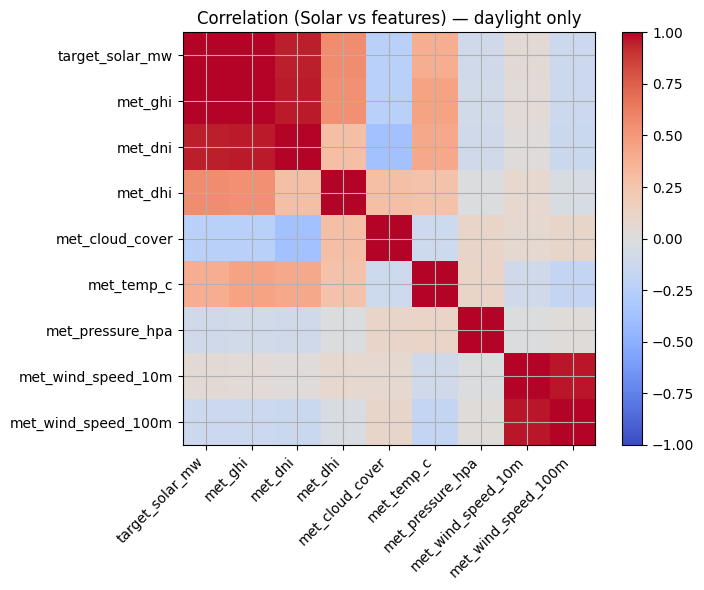

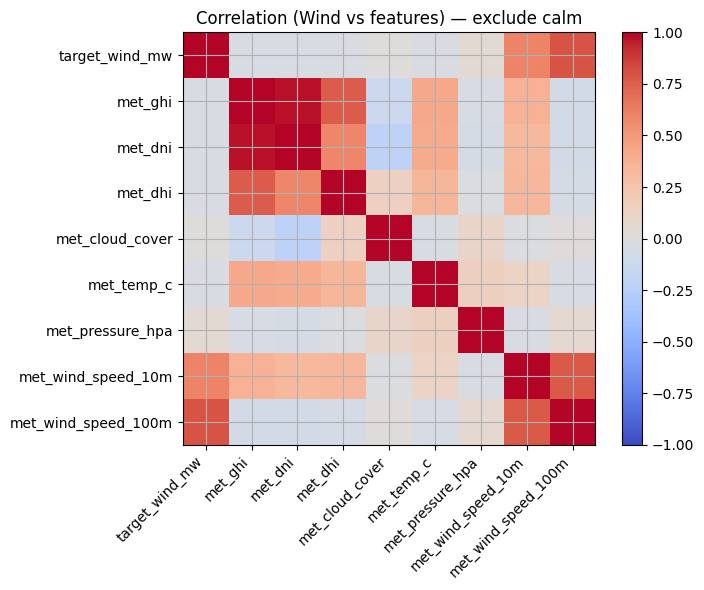

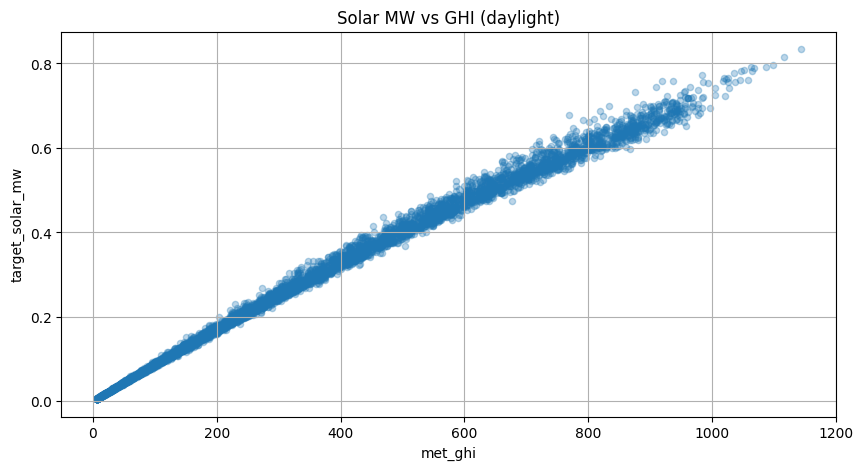

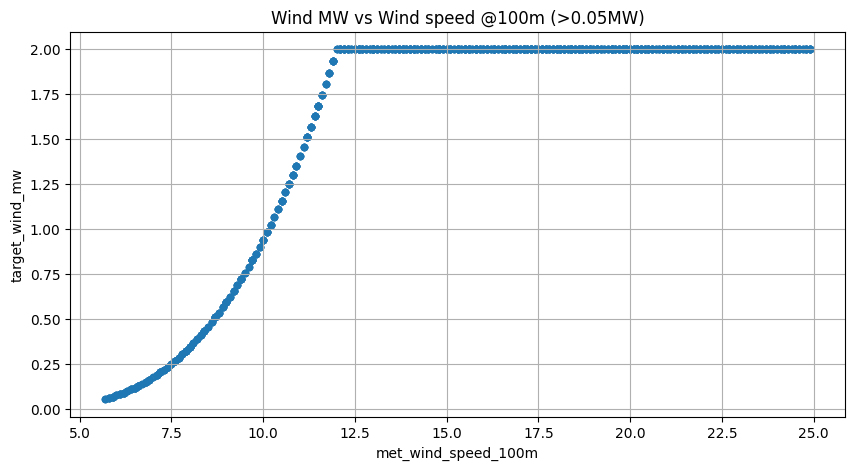

In [ ]:
core_features = [ghi_col, dni_col, dhi_col, cloud_col, temp_col, press_col, ws10_col, ws100_col, u10_col, v10_col, u100_col, v100_col]
core_features = [c for c in core_features if c and c in df.columns]

def corr_heatmap(target_col, mask=None, title=""):
    sub = df[[target_col] + core_features].copy()
    if mask is not None: sub = sub[mask]
    sub = sub.dropna()
    if sub.empty:
        print("No data for correlation plot:", title); return
    corr = sub.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title(title)
    plt.tight_layout(); plt.show()

if solar_col in df and core_features:
    corr_heatmap(solar_col, mask=df["is_daylight"], title="Correlation (Solar vs features) — daylight only")
if wind_col in df and core_features:
    corr_heatmap(wind_col, mask=~df["wind_near_zero"], title="Correlation (Wind vs features) — exclude calm")

def safe_scatter(xcol, ycol, mask=None, title=""):
    sub = df[[xcol, ycol]].copy()
    if mask is not None: sub = sub[mask]
    sub = sub.dropna()
    if sub.empty:
        print("No data for:", title); return
    ax = sub.sample(min(5000, len(sub)), random_state=42).plot.scatter(x=xcol, y=ycol, alpha=0.3)
    ax.set_title(title); plt.show()

if solar_col and ghi_col:
    safe_scatter(ghi_col, solar_col, mask=df["is_daylight"], title="Solar MW vs GHI (daylight)")
if wind_col and ws100_col:
    safe_scatter(ws100_col, wind_col, mask=~df["wind_near_zero"], title="Wind MW vs Wind speed @100m (>0.05MW)")


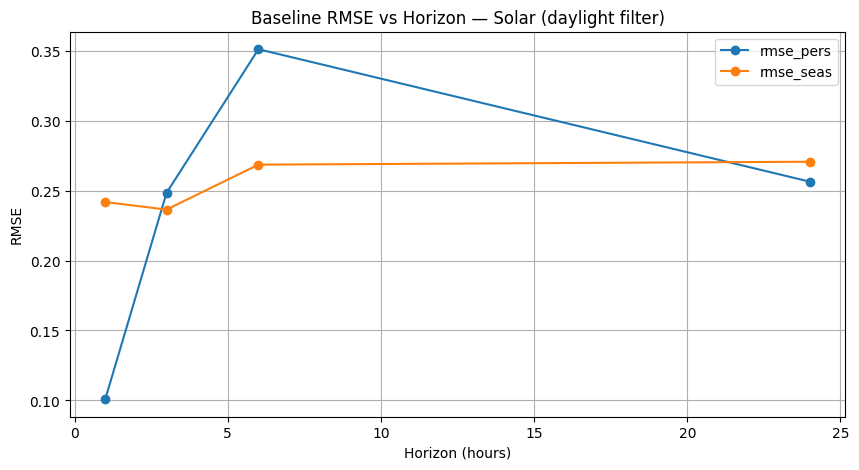

,h,rmse_pers,rmse_seas,mae_pers,mae_seas
0,1,0.100838,0.241827,0.084453,0.190886
1,3,0.248335,0.236425,0.210635,0.188386
2,6,0.351081,0.268552,0.295842,0.209720
3,24,0.256390,0.270634,0.198431,0.209107


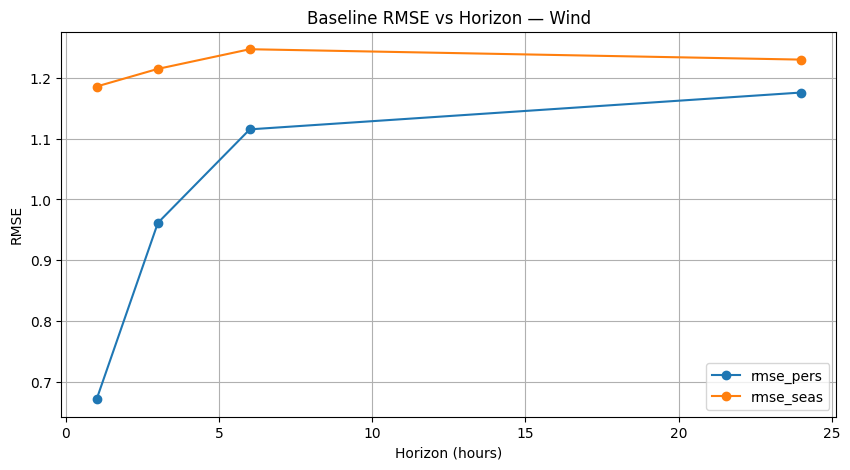

,h,rmse_pers,rmse_seas,mae_pers,mae_seas
0,1,0.671306,1.185742,0.294594,0.795503
1,3,0.961465,1.214741,0.547727,0.831731
2,6,1.115256,1.247072,0.712769,0.872778
3,24,1.175832,1.229990,0.783280,0.850623


In [ ]:
# --- compatibility RMSE (works with old and new sklearn) ---
def rmse(y_true, y_pred):
    try:
        # Newer sklearn (has 'squared' kwarg)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older sklearn: no 'squared' kwarg → take sqrt of MSE
        return np.sqrt(mean_squared_error(y_true, y_pred))

def baseline_curves(df_in, target_col, label, daylight=False):
    d = df_in[["ts_utc", site_col, target_col]].dropna().sort_values("ts_utc").copy()
    if daylight and "is_daylight" in df_in:
        d = d[df_in["is_daylight"]]

    results = []
    for H in HORIZONS:
        # Persistence: y_hat(t+H) = y(t)
        d[f"pers_pred_{H}h"] = d.groupby(site_col)[target_col].shift(0)
        d[f"truth_{H}h"]     = d.groupby(site_col)[target_col].shift(-H)

        # Seasonal-naïve: same hour yesterday
        d[f"seas_pred_{H}h"] = d.groupby(site_col)[target_col].shift(24)

        sub = d.dropna(subset=[f"truth_{H}h", f"pers_pred_{H}h", f"seas_pred_{H}h"])[
            [f"truth_{H}h", f"pers_pred_{H}h", f"seas_pred_{H}h"]
        ]
        if sub.empty:
            results.append({"h": H, "rmse_pers": np.nan, "rmse_seas": np.nan,
                            "mae_pers": np.nan, "mae_seas": np.nan})
            continue

        y = sub[f"truth_{H}h"].values
        p_pers = sub[f"pers_pred_{H}h"].values
        p_seas = sub[f"seas_pred_{H}h"].values

        results.append({
            "h": H,
            "rmse_pers": rmse(y, p_pers),
            "rmse_seas": rmse(y, p_seas),
            "mae_pers": mean_absolute_error(y, p_pers),
            "mae_seas": mean_absolute_error(y, p_seas),
        })

    res = pd.DataFrame(results)
    ax = res.set_index("h")[["rmse_pers","rmse_seas"]].plot(marker="o", title=f"Baseline RMSE vs Horizon — {label}")
    ax.set_xlabel("Horizon (hours)"); ax.set_ylabel("RMSE")
    plt.show()
    display(res)
    return res

# run baselines
solar_baselines = wind_baselines = None
if solar_col in df:
    solar_baselines = baseline_curves(df, solar_col, "Solar (daylight filter)", daylight=True)
if wind_col in df:
    wind_baselines = baseline_curves(df, wind_col, "Wind", daylight=False)


,feature,MI
0,met_ghi,5.412758
4,met_temp_c,4.200329
1,met_dni,1.482812
2,met_dhi,0.865721
3,met_cloud_cover,0.054969
5,met_pressure_hpa,0.027618
7,met_wind_speed_100m,0.013115
6,met_wind_speed_10m,0.006673


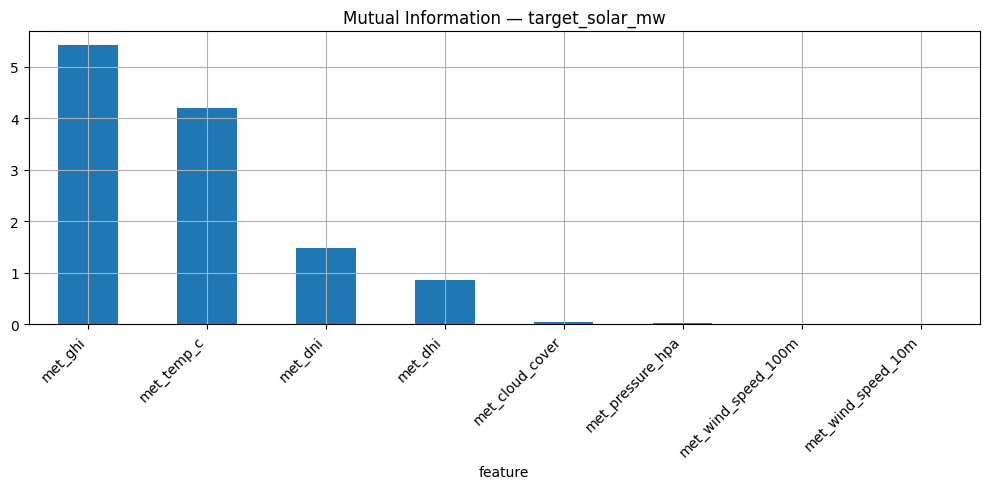

,feature,MI
7,met_wind_speed_100m,1.829893
6,met_wind_speed_10m,0.345876
5,met_pressure_hpa,0.008261
1,met_dni,0.003172
4,met_temp_c,0.003059
0,met_ghi,0.002196
2,met_dhi,0.001735
3,met_cloud_cover,0.000000


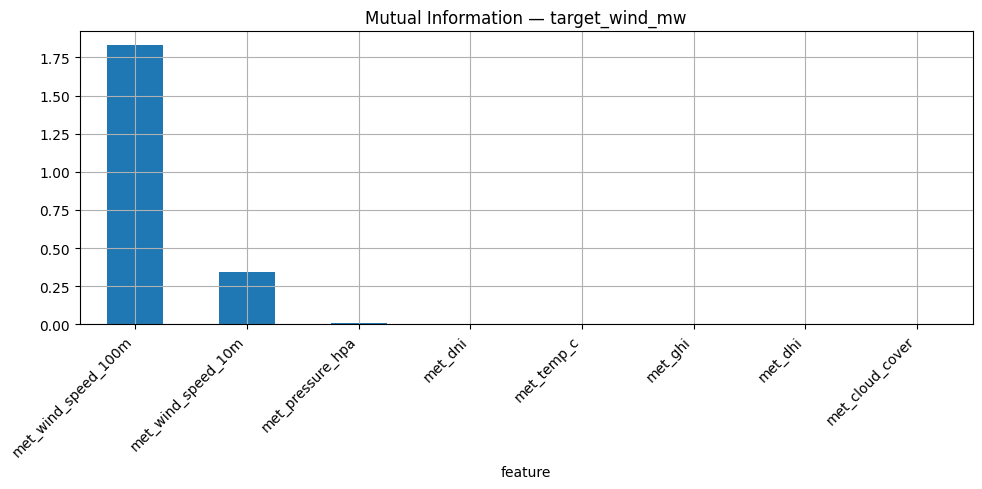

In [ ]:
def feature_ranking(target_col, mask=None, top_k=15):
    feats = [c for c in core_features if c in df.columns]
    sub = df[[target_col] + feats].copy()
    if mask is not None: sub = sub[mask]
    sub = sub.dropna()
    if len(sub) < 500:
        print("Not enough rows for MI ranking:", target_col); return None
    X = sub[feats].astype(float); y = sub[target_col].astype(float)
    mi = mutual_info_regression(X, y, random_state=42)
    rank = pd.DataFrame({"feature": feats, "MI": mi}).sort_values("MI", ascending=False).head(top_k)
    display(rank)
    rank.plot.bar(x="feature", y="MI", legend=False, title=f"Mutual Information — {target_col}")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
    return rank

solar_rank = wind_rank = None
if solar_col in df and core_features:
    solar_rank = feature_ranking(solar_col, mask=df["is_daylight"])
if wind_col in df and core_features:
    wind_rank = feature_ranking(wind_col, mask=~df["wind_near_zero"])


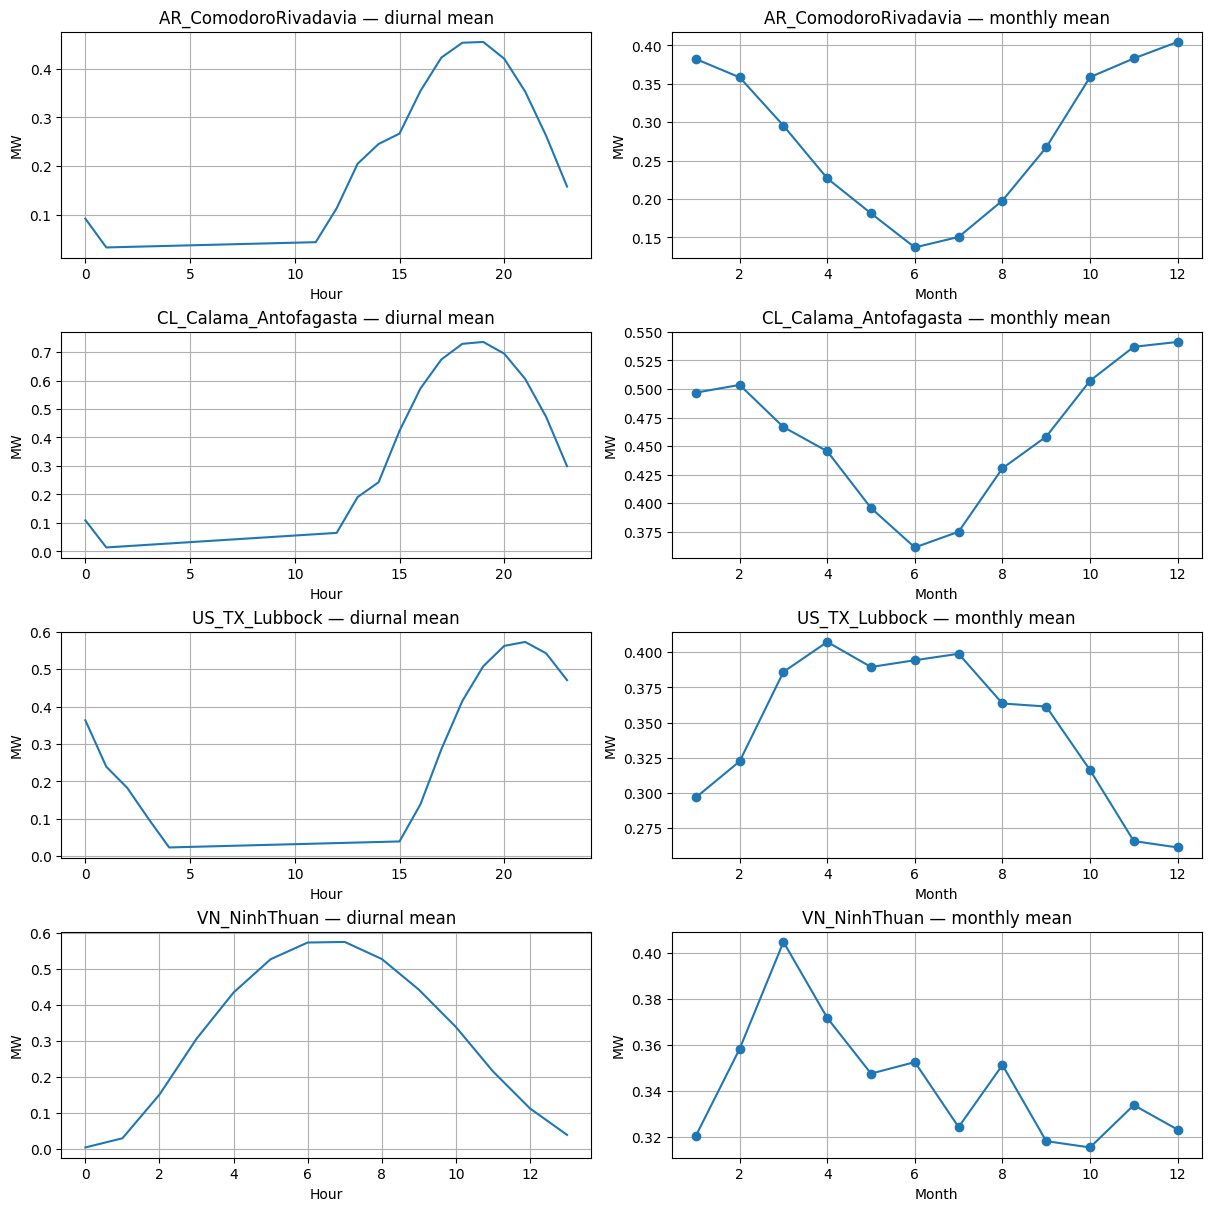

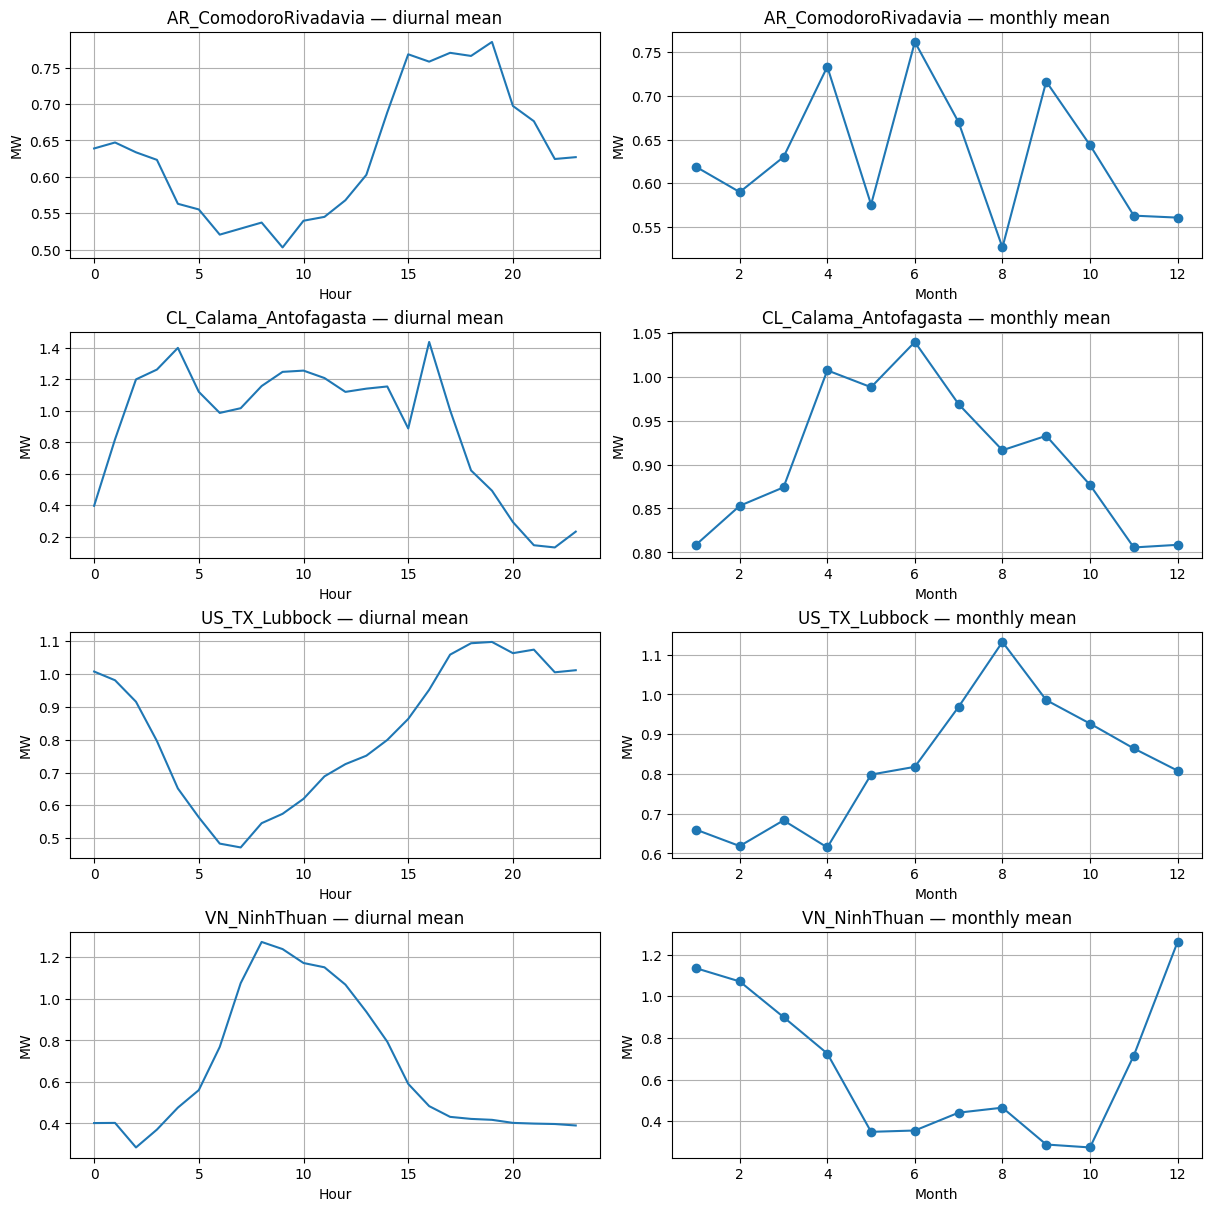

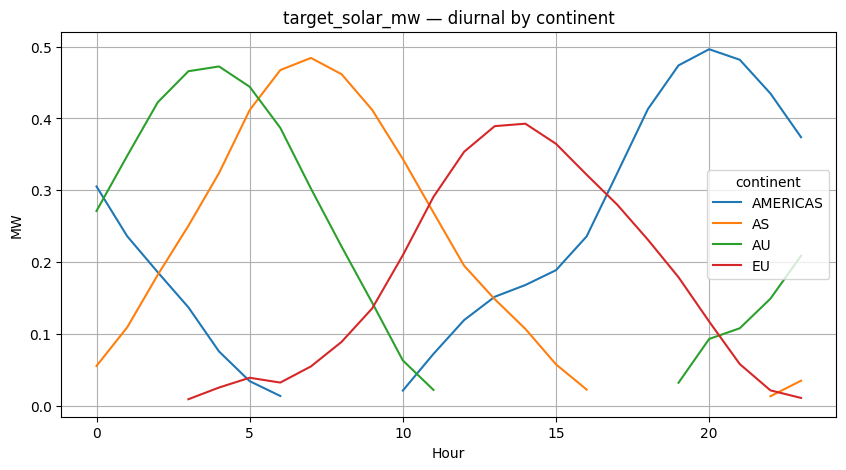

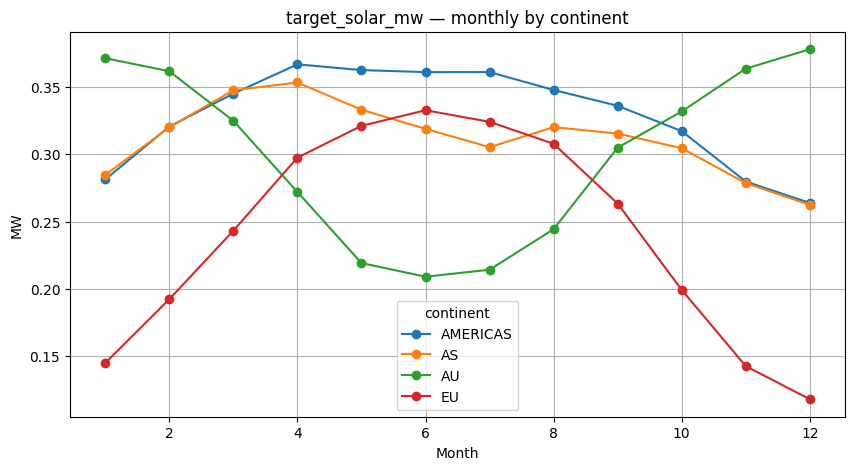

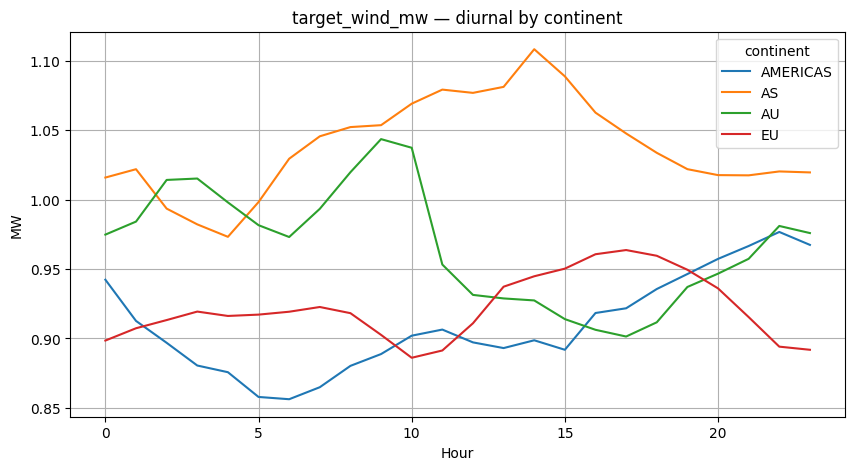

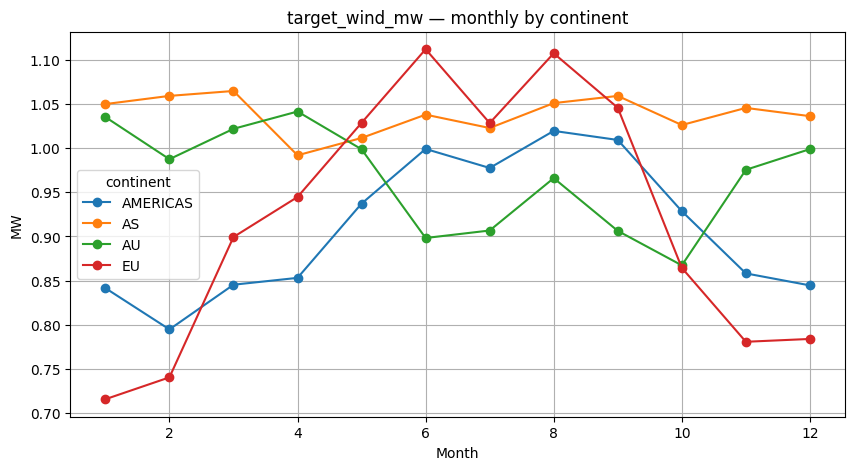

In [ ]:
def site_preview(target_col, n_sites=4, daylight=False):
    sites = df[site_col].dropna().unique().tolist()[:n_sites]
    if not sites:
        print("No site column available for preview"); return
    fig, axes = plt.subplots(len(sites), 2, figsize=(12, 3*len(sites)), constrained_layout=True)

    for i, sid in enumerate(sites):
        sub = df[df[site_col] == sid]
        if daylight and "is_daylight" in sub.columns: sub = sub[sub["is_daylight"]]
        diur = sub.groupby("hour")[target_col].mean()
        mon  = sub.groupby("month")[target_col].mean()

        (axes[i,0] if len(sites)>1 else axes[0]).plot(diur);
        (axes[i,0] if len(sites)>1 else axes[0]).set_title(f"{sid} — diurnal mean");
        (axes[i,0] if len(sites)>1 else axes[0]).set_xlabel("Hour");
        (axes[i,0] if len(sites)>1 else axes[0]).set_ylabel("MW")

        (axes[i,1] if len(sites)>1 else axes[1]).plot(mon, marker="o");
        (axes[i,1] if len(sites)>1 else axes[1]).set_title(f"{sid} — monthly mean");
        (axes[i,1] if len(sites)>1 else axes[1]).set_xlabel("Month");
        (axes[i,1] if len(sites)>1 else axes[1]).set_ylabel("MW")
    plt.show()

# peek by site
if solar_col in df:
    site_preview(solar_col, n_sites=4, daylight=True)
if wind_col in df:
    site_preview(wind_col, n_sites=4, daylight=False)

# quick continent-level contrast
def continent_profile(target_col, daylight=False):
    sub = df.copy()
    if daylight and "is_daylight" in sub.columns: sub = sub[sub["is_daylight"]]
    diur = sub.groupby(["continent","hour"])[target_col].mean().unstack(0)
    diur.plot(title=f"{target_col} — diurnal by continent"); plt.xlabel("Hour"); plt.ylabel("MW"); plt.show()
    mon = sub.groupby(["continent","month"])[target_col].mean().unstack(0)
    mon.plot(title=f"{target_col} — monthly by continent", marker="o"); plt.xlabel("Month"); plt.ylabel("MW"); plt.show()

if solar_col in df:
    continent_profile(solar_col, daylight=True)
if wind_col in df:
    continent_profile(wind_col, daylight=False)


In [ ]:
from google.colab import files
import os

# Define the target directory in Google Drive
drive_dir = '/content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent'
file_path = os.path.join(drive_dir, 'refined_df.csv')

# Ensure the directory exists
os.makedirs(drive_dir, exist_ok=True)

# Save the dataframe to the specified path in Google Drive
df.to_csv(file_path, index=False)

# Print a message indicating the file has been saved
print(f"DataFrame 'df' saved to '{file_path}'")

DataFrame 'df' saved to '/content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/refined_df.csv'
